In [1]:
!pip install transformers datasets

     |████████████████████████████████| 3.8 MB 5.0 MB/s 
     |████████████████████████████████| 325 kB 49.6 MB/s 
     |████████████████████████████████| 6.5 MB 38.8 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 67 kB 1.8 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 136 kB 53.8 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 212 kB 62.4 MB/s 
     |████████████████████████████████| 127 kB 56.2 MB/s 
     |████████████████████████████████| 271 kB 57.5 MB/s 
     |████████████████████████████████| 144 kB 53.1 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [2]:
# # For Weights and Biases
# !pip install -qq wandb

# # For MLOps
# import wandb
# print("W&B: ", wandb.__version__)
# from wandb.keras import WandbCallback

# # Login to W&B
# wandb.login()
# #API Key: fa80f1e2568b4a415575ed43b0c000482e7eb0f3

# #Initialise Weights and biases run
# wandb.init()

In [3]:
import numpy as np
import pandas as pd
import os
import json
import random

import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import sklearn

# Config File

In [4]:
#Config File

# -----
# directory locations
# -----
# google drive file loca
gdrive_mount = "/content/drive"
ROOT_DIR = gdrive_mount # "."

# CHANGE IS AS NEEDED
# this value is join with ROOT_DIR
my_path_in_drive_experiments = "My Drive/Coursework 1/experiments"


####Data Configs
#Column to be used as label for training and flipping labels
label_col = 'weak_label'

#Decide if weak labels should be overwritten and with what column
overwrite_weak_labels = True
weak_label_file = 'weak_labels_995.csv'

# split file - being apple to specify the file may be useful, 
# - particularly for augmented data
split_file = "df_full_aug_wl_995.tsv"


#Flipping Labels
flip_labels = False
exclude_bidirectional = True
flip_val_and_test = True
#Synthetic positives
add_synthetic_positives = False
#Mask entity names
mask_entity_names = False
#Training with data at instance of bag level
instance_level = True


###Model Configs
#Model params
base_model = "distilbert-base-uncased"

####Trainingn configs
#Should BERT Layers be frozen during training
only_train_classifier = False
fine_tune_model = True

###Evaluation Config
#Decide if best or last model should be loaded
load_best = True
load_last = False

#Decide which label is used to evaluate
evaluation_label = "KB_label"

#Model folder
model_folder = 'dataset_04_05_weaklabel_w_aug'

# values that will be considered a positive gold label
pos_labels = ["Supplier", "partnership", "owner"]

###Create model string
model_string_flipped_label = "FlippedLabel" if flip_labels else "NoFlippedLabel"
model_string_label_col = label_col
model_string_instance_level = 'InstanceLevel' if instance_level else "BagLevel"
model_string_synthetic_positives = 'SynthPos' if add_synthetic_positives else "NoSynthPos"
model_string_mask_entity_names = "NamesMasked" if mask_entity_names else 'NamesVisible'
model_string_optional = "Base"
model_string_end = 'tf'

model_string = '_'.join([base_model,model_string_flipped_label,model_string_instance_level,model_string_synthetic_positives,model_string_mask_entity_names,model_string_optional,model_string_end])
model_string


# store parameters in dict - so can write to file
param_dict = {}
param_dict["label_col"] = label_col
param_dict["overwrite_weak_labels"] = overwrite_weak_labels
param_dict["weak_label_file"] = weak_label_file
param_dict["flip_labels"] = flip_labels
param_dict["exclude_bidirectional"] = exclude_bidirectional
param_dict["flip_val_and_test"] = flip_val_and_test
param_dict["add_synthetic_positives"] = add_synthetic_positives
param_dict["mask_entity_names"] = mask_entity_names
param_dict["instance_level"] = instance_level
param_dict["base_model"] = base_model
param_dict["model_folder"] = model_folder
param_dict["split_file"] = split_file
param_dict["pos_labels"] = pos_labels




# Data Augmentation Functions

In [5]:
def data_augment_flip_labels(df_data,label_col = 'label',exclude_bidirectional = True):
  #Add a marker for labels that were flipped
  df_data.loc[:,'flipped'] = 0

  
  #Take all positive examples and flip the entities and labels - Depending on exclude_bidirectional we do not flip some pairs that have relationships in both ways in the KB
  if exclude_bidirectional==True:
    flipped_examples = (df_data[label_col] == 1) & (np.logical_not(df_data.loc[:,'pair'].isin(df_bidirectional.loc[:,'pair'])))
  else:
    flipped_examples = df_data[label_col] == 1  
  
  #Copy the data for the pairs to be flipped
  df_data_pos = df_data.loc[flipped_examples,:].copy()

  #Set all columns with to NA
  df_data_pos.loc[:,:] = np.nan 
  
  #Set columns
  df_data_pos.loc[:,'flipped'] = 1
  df_data_pos.loc[:,label_col] = 0
  
  #Recover certain columns
  for rec_col in ['start_sent', 'end_sent', 'text','num_sentence', 'article','date_publish', 'source_domain','sentence_range','num_chars', 'num_tokens', 'text_with_marker', 'split']:
       df_data_pos.loc[:,rec_col] = df_data.loc[flipped_examples,rec_col]

  #Create a new id for flipped examples
  df_data_pos.loc[:,'id'] = df_data.loc[flipped_examples,'id'] + "_flipped"


  #Change entity order
  df_data_pos.loc[:,'entity1'] = df_data.loc[flipped_examples,'entity2']
  df_data_pos.loc[:,'entity2'] = df_data.loc[flipped_examples,'entity1']
  df_data_pos.loc[:,'entity1_full'] = df_data.loc[flipped_examples,'entity2_full']
  df_data_pos.loc[:,'entity2_full'] = df_data.loc[flipped_examples,'entity1_full']

  #Surround all entity1 mentions in full_sentence with []
  df_data_pos.loc[:,"text_with_marker"] = [row[0].replace('{'+row[1]+'}','['+row[1]+']') for row in zip(df_data_pos['text_with_marker'],df_data_pos['entity2'])]
  #Surround all entity2 mentions in full_sentence with {}
  df_data_pos.loc[:,"text_with_marker"] = [row[0].replace('['+row[1]+']','{'+row[1]+'}') for row in zip(df_data_pos['text_with_marker'],df_data_pos['entity1'])]

  df_data = pd.concat([df_data,df_data_pos],axis=0)
  df_data.reset_index(drop=True,inplace=True)

  return df_data



In [6]:
#Print out a few examples to check fi flipped - DOES NOT ALWAYS PRINT SENTENCES TO COMPARE
def check_label_flip(df_split_train):
  #Check if the new labelling worked out right
  k = random.randrange(0, df_split_train.shape[0]-1, 2)
  e1 = df_split_train["entity1"].values[k]
  e2 = df_split_train["entity2"].values[k]

  # e1 = 'Ford'
  # e2 = 'Zhejiang Geely'

  mask = ((df_split_train["entity1"]==e1) & (df_split_train["entity2"]==e2) | (df_split_train["entity1"]==e2) & (df_split_train["entity2"]==e1))

  #df_data_split.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).head()
  i = 0
  print(df_split_train.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).loc[i,"text_with_marker"])
  print(df_split_train.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).loc[i,"KB_label"])
  print(df_split_train.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).loc[i,"flipped"])
  print(df_split_train.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).loc[i+1,"text_with_marker"])
  print(df_split_train.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).loc[i+1,"KB_label"])
  print(df_split_train.loc[mask,:].sort_values(['article','num_sentence']).reset_index(drop=True).loc[i+1,"flipped"])


# Load DataSet

In [7]:
#Mount GDrive
from google.colab import drive
# ROOT_DIR = "."
drive.mount(gdrive_mount)

#CHANGE THIS TO YOUR PATH TO THE DATA INSIDE THE GDRIVE
# ROOT_DIR = os.path.abspath(".")

#Path to (data) files
RAW_DATA_DIR = os.path.join(ROOT_DIR, my_path_in_drive_experiments,'data')

Mounted at /content/drive


In [8]:
#Set model path where things get stored
model_path = os.path.join(ROOT_DIR, my_path_in_drive_experiments,'models',model_folder,model_string)
if os.path.isdir(model_path)==False:
  print("Creating path for the model, this means you need to train and store the model first")
  print(model_path)
  os.makedirs(model_path)  


Creating path for the model, this means you need to train and store the model first
/content/drive/My Drive/Coursework 1/experiments/models/dataset_04_05_weaklabel_w_aug/distilbert-base-uncased_NoFlippedLabel_InstanceLevel_NoSynthPos_NamesVisible_Base_tf


In [9]:
# save the parameter config down
with open(os.path.join(model_path, "params.json"), "w") as f:
    json.dump(param_dict, f, indent=4)

## Loading dataset already split and performing data augmentation

In [10]:
#Import files

# df_split_train = pd.read_csv(RAW_DATA_DIR + '/df_train_stanford.tsv', sep = '\t',index_col=0)
# df_split_val = pd.read_csv(RAW_DATA_DIR + '/df_val_stanford.tsv', sep = '\t',index_col=0)
# df_split_test = pd.read_csv(RAW_DATA_DIR + '/df_test_stanford.tsv', sep = '\t',index_col=0)

#Full data

df_split_full = pd.read_csv(os.path.join(RAW_DATA_DIR,split_file), sep = '\t', na_filter=False)

# if add_synthetic_positives:
#   df_split_full = pd.read_csv(RAW_DATA_DIR + , sep = '\t')
# else:
#   df_split_full = pd.read_csv(RAW_DATA_DIR + '/df_full.tsv', sep = '\t')

if overwrite_weak_labels:
    print("over writing weak labels with labels from:")
    print(weak_label_file)
    #Add here what we should do with weak labels
    #Load Weak Label File and overwrite weak_label column in df_full
    df_weak_labels_new = pd.read_csv(os.path.join(RAW_DATA_DIR, weak_label_file))
    df_weak_labels_new.rename(columns={'label_id':"id"},inplace=True)
    df_split_full.drop('weak_label',inplace=True,axis=1)
    df_split_full = pd.merge(df_split_full, df_weak_labels_new, how='left', on='id')


#Splitting the data
# TODO: don't really need to split data apart, could just select subset when needed
df_split_train = df_split_full.loc[df_split_full['split'] == 0,:].copy()
df_split_val = df_split_full.loc[df_split_full['split'] == 1,:].copy()
df_split_test = df_split_full.loc[df_split_full['split'] == 2,:].copy()


#Load the bi-directional pairs csv
if exclude_bidirectional==True:
    print(f"exclude_bidirectional: {exclude_bidirectional}")
    df_bidirectional = pd.read_csv(RAW_DATA_DIR + '/bidirectional_supplier_relations.csv')
    df_bidirectional.loc[:,'pair'] = df_bidirectional.loc[:,'entity1'] + '|' + df_bidirectional.loc[:,'entity2']

over writing weak labels with labels from:
weak_labels_995.csv
exclude_bidirectional: True


In [11]:
df_split_full.head(3)

,id_,start_sent,end_sent,relation,entity1_full,entity2_full,num_sentence,article,date_publish,source_domain,...,KB_label,text_with_marker,most_conf,pair,split,entity1,entity2,text,weak_label,prob_label_y
0,e4d31990950218ed67498f401e03ae58c4c7d69b081d59...,28,29,,A123 Systems Inc,Ford Motor Co,2,e4d31990950218ed67498f401e03ae58c4c7d69b081d59...,2012-12-09 05:15:54,uk.reuters.com,...,0,Wanxiang generates about $1 billion in revenue...,True,A123 Systems Inc|Ford Motor Co,0,A123,Ford,Wanxiang generates about $1 billion in revenue...,0,0.026540
1,14a66cf6e11b6a364ef60e05a6ee7cda44066892eb3aac...,10,11,,AAC Technologies Holdings Inc,LG Innotek Co Ltd,2,14a66cf6e11b6a364ef60e05a6ee7cda44066892eb3aac...,2018-11-06 03:43:50,www.reuters.com,...,0,Hong Kong-based acoustic components supplier {...,True,AAC Technologies Holdings Inc|LG Innotek Co Ltd,2,AAC,LG Innotek,Hong Kong-based acoustic components supplier A...,0,0.137192
2,1429be39f996af8c8d2401d9619b74a83b28c78744f7ce...,23,24,,AAC Technologies Holdings Inc,LG Innotek Co Ltd,2,1429be39f996af8c8d2401d9619b74a83b28c78744f7ce...,2018-11-13 06:48:56,www.reuters.com,...,0,"Among other Apple suppliers in Asia, Hong Kong...",True,AAC Technologies Holdings Inc|LG Innotek Co Ltd,2,AAC,LG Innotek,"Among other Apple suppliers in Asia, Hong Kong...",0,0.037591


In [12]:
#Apply Data Augmentation
if flip_labels==True:
  df_split_train = data_augment_flip_labels(df_split_train, label_col = label_col)
  df_split_val.loc[:,"flipped"] = 0 
  df_split_test.loc[:,"flipped"] = 0

  #print new balance
  print("")
  print('Train: Added {} new negative examples. Balance is now {}, down from {}'.format(df_split_train.loc[df_split_train['flipped']==1,:].shape[0],df_split_train.loc[:,label_col].mean(),df_split_train.loc[df_split_train['flipped']==0,label_col].mean()))
  print("")

  if flip_val_and_test==True:
    df_split_val = data_augment_flip_labels(df_split_val, label_col = label_col)
    df_split_test = data_augment_flip_labels(df_split_test, label_col = label_col)

    print("")
    print('Val: Added {} new negative examples. Balance is now {}, down from {}'.format(df_split_val.loc[df_split_val['flipped']==1,:].shape[0],df_split_val.loc[:,label_col].mean(),df_split_val.loc[df_split_val['flipped']==0,label_col].mean()))
    print("")

    print("")
    print('Test: Added {} new negative examples. Balance is now {}, down from {}'.format(df_split_test.loc[df_split_test['flipped']==1,:].shape[0],df_split_test.loc[:,label_col].mean(),df_split_test.loc[df_split_test['flipped']==0,label_col].mean()))
    print("")



In [13]:
#Print out a few test cases to check:
if flip_labels==True:
  check_label_flip(df_split_train)
  check_label_flip(df_split_train)
  check_label_flip(df_split_train)


In [14]:
#Set label for model to be trained on 
df_split_train.loc[:,'label'] = df_split_train.loc[:,label_col]
df_split_val.loc[:,'label'] = df_split_val.loc[:,label_col]
df_split_test.loc[:,'label'] = df_split_test.loc[:,label_col]


In [15]:
# require label col >= 0 for train and val data
# - this matters when weak labels are used and some labels abstain: -1
df_split_train = df_split_train.loc[df_split_train['label'] >= 0]
df_split_val = df_split_val.loc[df_split_val['label'] >= 0]

## Store in CSVs to be loadad into huggingface

In [16]:
#Do we need to mark the files somehow so we can evaluate later?
#Set file names for dataset to be loaded into BERT
processed_file_name_train = "data_train.csv"
processed_file_name_val = "data_val.csv"
processed_file_name_test = "data_test.csv"



In [17]:
#Save the dataframe to a csv for import as huggingface dataset
df_split_train.to_csv(os.path.join(ROOT_DIR, model_path,processed_file_name_train),index=False )
df_split_val.to_csv(os.path.join(ROOT_DIR, model_path,processed_file_name_val),index=False )
df_split_test.to_csv(os.path.join(ROOT_DIR, model_path,processed_file_name_test),index=False )


# Following HuggingFace Dataset Tokenization approach

In [18]:
from datasets import load_dataset, load_from_disk

In [19]:
#Loading data into HuggingFace Dataset:
dataset = load_dataset('csv', data_files={'train': os.path.join(ROOT_DIR, model_path,processed_file_name_train),'val': os.path.join(ROOT_DIR, model_path,processed_file_name_val), 'test': os.path.join(ROOT_DIR, model_path,processed_file_name_test)})

Using custom data configuration default-1cc903cc4f3f6754


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1cc903cc4f3f6754/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
for i in range(5):
    print("-" * 50)
    print(dataset['train']['text_with_marker'][i])

--------------------------------------------------
Wanxiang generates about $1 billion in revenue in the United States by supplying parts to GM and [Ford] and has bought or invested in more than 20 U.S. companies, many of them in bankruptcy, said a congressional report. Those past investments could help Wanxiang get approval to buy {A123}, but the deal will be closely scrutinized because it involves advanced technology, said Andrew Szamosszegi, who wrote the report for the U.S.-China Economic and Security Review Commission.
--------------------------------------------------
The remarks by Mizuho Bank CEO Koji Fujiwara come as major Japanese companies, including airline operator {ANA} and retailer [Aeon], have recently secured funds through subordinated loans.
--------------------------------------------------
Japanese airline {ANA} is set to order 18 [Airbus] A320neo jets, a source familiar with the matter said on Tuesday.
--------------------------------------------------
--{ANA} {ANA

In [21]:
#Using AutoTokenizer 
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [22]:
def preprocess_function(examples):
    return tokenizer(examples["text_with_marker"], truncation=True) #,padding=True,max_length=128

In [23]:
#Tokenizing using the tokenizer above gives a dict with lists for each input 
tokenized_dataset = dataset.map(preprocess_function, batched=True)


  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [24]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id_', 'start_sent', 'end_sent', 'relation', 'entity1_full', 'entity2_full', 'num_sentence', 'article', 'date_publish', 'source_domain', 'e1', 'e2', 'sentence_range', 'id', 'num_chars', 'num_tokens', 'Confidence Score (%)', 'e2_count', 'epair_count', 'companies_in_text', 'prob_label_x', 'KB_label', 'text_with_marker', 'most_conf', 'pair', 'split', 'entity1', 'entity2', 'text', 'weak_label', 'prob_label_y', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16763
    })
    val: Dataset({
        features: ['id_', 'start_sent', 'end_sent', 'relation', 'entity1_full', 'entity2_full', 'num_sentence', 'article', 'date_publish', 'source_domain', 'e1', 'e2', 'sentence_range', 'id', 'num_chars', 'num_tokens', 'Confidence Score (%)', 'e2_count', 'epair_count', 'companies_in_text', 'prob_label_x', 'KB_label', 'text_with_marker', 'most_conf', 'pair', 'split', 'entity1', 'entity2', 'text', 'weak_label', 'prob_label_y', 'label', 'input_

In [25]:
#Store for re-producablility
tokenized_dataset.save_to_disk(model_path + "/tokenized_dataset")

In [26]:
#Check token length
tokensdf = pd.DataFrame(tokenized_dataset['train']['input_ids'])
num_token_per_sent = tokensdf.iloc[:,:].apply(lambda x: len(x.dropna()),axis=1)
np.histogram(num_token_per_sent)

(array([9621, 6071,  492,  148,  124,   68,   30,   26,   25,  158]),
 array([ 13. ,  62.9, 112.8, 162.7, 212.6, 262.5, 312.4, 362.3, 412.2,
        462.1, 512. ]))

Text(0.5, 1.0, 'Histogram of #Tokens per Sentence')

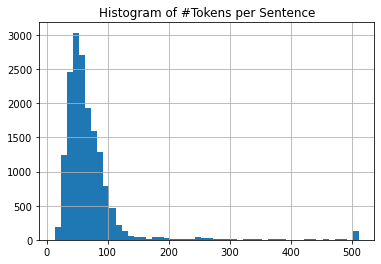

In [27]:
pd.DataFrame(num_token_per_sent).hist(bins=50)
plt.title("Histogram of #Tokens per Sentence")

## Fine Tune using Tensorflow

In [28]:
#Using Tensorflow

In [29]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

In [30]:
batch_size = 16

In [31]:
tf_train_set = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols = ['label'],
    shuffle=True, #For inference we recreate this and set to False
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_dataset["val"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols = ['label'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_test_set = tokenized_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols = ['label'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


In [32]:
# #Use small set for testing purposes
# tf_train_set = tf_train_set.take(50)
# tf_validation_set = tf_validation_set.take(10)
# tf_test_set = tf_test_set.take(10)

In [33]:
#Set up an optimizer function, learning rate schedule, and some training hyperparameters:
from transformers import create_optimizer
import tensorflow as tf

batch_size = batch_size
num_train_epochs = 5
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_train_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [34]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(base_model, num_labels=2)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [35]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [36]:
#Freeze all distilbert layers
#Existing layers are: ['distilbert', 'pre_classifier', 'classifier', 'dropout_19']

if only_train_classifier:
  for _layer in model.layers:
      if _layer.name == 'distilbert':
          print(f"Freezing model layer: {_layer.name}")
          _layer.trainable = False
      print(f'Layer: {_layer.name}, Trainable: {_layer.trainable}')

In [37]:
#Look at the layers 
model.summary(show_trainable=True)

#You can use this to get a more detailed overview of param choices
#model.get_config()

Model: "tf_distil_bert_for_sequence_classification"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 distilbert (TFDistilBertMai  multiple                 66362880  Y          
 nLayer)                                                                    
                                                                            
 pre_classifier (Dense)      multiple                  590592    Y          
                                                                            
 classifier (Dense)          multiple                  1538      Y          
                                                                            
 dropout_19 (Dropout)        multiple                  0         Y          
                                                                            
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_______________________

In [38]:
#Compile
model.compile(optimizer=optimizer, loss = loss)

In [39]:
#Add Callbacks 
from transformers.keras_callbacks import KerasMetricCallback

#Metric Callback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_predictions):
    #Get predictions and labels
    predictions, labels = eval_predictions
    #Get prediction as argmax
    predictions = np.argmax(predictions, axis=1)
    #Calc metric
    precision, recall, f1, support = precision_recall_fscore_support(labels, predictions, beta=0.5)
    acc = accuracy_score(labels, predictions)
    return {
        
        'precision': precision[1],
        'recall': recall[1],
        'f1': f1[1],
        'support': support[1],
        'accuracy': acc
    }

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_set)



# Save 'best' model
# NOTE: the location where modes are being saved
# - saved weights can take up ~100MB - make sure you have the space
checkpoint_finetune_filepath = os.path.join(model_path,'Best',"tf_model.h5")
# logger files
logger_finetune_filepath = os.path.join(model_path,"task_fine_tuning_logger.csv")


# best performing model checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_finetune_filepath,
    #filepath=model_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


#Check if we really want this one
# early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0,
    mode='min', baseline=None, restore_best_weights=False
)

# training log
csv_logger = tf.keras.callbacks.CSVLogger(
    logger_finetune_filepath,
    separator=',',
    append=False
)

callbacks = [metric_callback,model_checkpoint_callback,early_stop,csv_logger]

In [40]:
#Train and store weights in case flag is true
if fine_tune_model:
  ###THIS IS A BIT OF A HACK BECAUSE WE USE THIS ONLY TO CREATE THE DIRECTORY OF THE MODEL AND THEN OVERWRITE THE tf_model.5h FILE WITH THE BEST MODEL CHECKPOINT

  #Save the model for re-producability
  model.save_pretrained(os.path.join(ROOT_DIR, model_path,"Best"))


  #Fine Tune the model
  model.fit(
      tf_train_set,
      validation_data=tf_validation_set,
      epochs=num_train_epochs,
      callbacks = callbacks
  )

  #Store the weights from the last epoch
  model.save_pretrained(os.path.join(ROOT_DIR,model_path,"LastEpoch"))

Epoch 1/5
1047/1047 [==============================] - 479s 447ms/step - loss: 0.2780 - val_loss: 0.8266 - precision: 0.7002 - recall: 0.3070 - f1: 0.5574 - support: 1179.0000 - accuracy: 0.7677
Epoch 2/5
1047/1047 [==============================] - 455s 435ms/step - loss: 0.0890 - val_loss: 0.9808 - precision: 0.6951 - recall: 0.2901 - f1: 0.5434 - support: 1179.0000 - accuracy: 0.7641
Epoch 3/5
1047/1047 [==============================] - 451s 431ms/step - loss: 0.0416 - val_loss: 1.2205 - precision: 0.6610 - recall: 0.2943 - f1: 0.5291 - support: 1179.0000 - accuracy: 0.7586


## Inference

In [86]:
#Loading the model:
### We get some warnings below about some layers missing etc. It seems that this is some sort of bug. Dropout layers have no weights so that should not matter. When I checked the model that is loaded from the file predcited exaclty the same as the file trained in the same session: https://discuss.huggingface.co/t/message-some-layers-from-the-model-were-not-used/1972/6

if load_best:
  model = TFAutoModelForSequenceClassification.from_pretrained(os.path.join(model_path,'Best'))
  print("")
  print(f"Loaded Best Model from {os.path.join(model_path,'Best')}")

elif load_last:
  model = TFAutoModelForSequenceClassification.from_pretrained(os.path.join(model_path,'LastEpoch'))
  print("")
  print(f"Loaded LastEpoch Model from {os.path.join(model_path,'LastEpoch')}")

else:
  print("Specify if last or best model should be loaded ")


Some layers from the model checkpoint at /content/drive/My Drive/Coursework 1/experiments/models/dataset_04_05_weaklabel_w_aug/distilbert-base-uncased_NoFlippedLabel_InstanceLevel_NoSynthPos_NamesVisible_Base_tf/LastEpoch were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/Coursework 1/experiments/models/dataset_04_05_weaklabel_


Loaded LastEpoch Model from /content/drive/My Drive/Coursework 1/experiments/models/dataset_04_05_weaklabel_w_aug/distilbert-base-uncased_NoFlippedLabel_InstanceLevel_NoSynthPos_NamesVisible_Base_tf/LastEpoch


In [87]:
#Load Datasets

#Re-load data from the csv

#Loading data into HuggingFace Dataset:
tokenized_dataset = load_from_disk(model_path + "/tokenized_dataset")

tf_train_set_forinf = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols = ['label'],
    shuffle=False, #For inference we recreate this and set to False
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_dataset["val"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols = ['label'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_test_set = tokenized_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols = ['label'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)





In [111]:
#Make predictions on a dataset -> output will be logits that need to be converted to distribution using softmax
prediction_train_forinf = model.predict(tf_train_set_forinf)
#Predict using softmax of the logits
predicted_labels_train_forinf = tf.nn.softmax(prediction_train_forinf['logits'], axis=None, name=None).numpy()
#True labels from above 
# true_labels_train_forinf = np.concatenate([y for x,y in tf_train_set_forinf], axis=0)


In [89]:
#Make predictions on a dataset -> output will be logits that need to be converted to distribution using softmax
prediction_val = model.predict(tf_validation_set)
#Predict using softmax of the logits
predicted_labels_val = tf.nn.softmax(prediction_val['logits'], axis=None, name=None).numpy()
#True labels from above 
# true_labels_val = np.concatenate([y for x,y in tf_validation_set], axis=0)

In [90]:
#Make predictions on a dataset -> output will be logits that need to be converted to distribution using softmax
prediction_test = model.predict(tf_test_set)
#Predict using softmax of the logits
predicted_labels_test = tf.nn.softmax(prediction_test['logits'], axis=None, name=None).numpy()
#True labels from above 
# true_labels_test = np.concatenate([y for x,y in tf_test_set], axis=0)

In [91]:
#Store train predictions
df_predicted_labels_train_forinf = pd.DataFrame(predicted_labels_train_forinf,columns=['prediction_0','prediction_1'])
df_predicted_labels_train_forinf.to_csv(model_path + "/predicted_labels_train.csv",index=False)

#Store val predictions
df_predicted_labels_val = pd.DataFrame(predicted_labels_val,columns=['prediction_0','prediction_1'])
df_predicted_labels_val.to_csv(model_path + "/predicted_labels_val.csv",index=False)

#Store test predictions
df_predicted_labels_test = pd.DataFrame(predicted_labels_test,columns=['prediction_0','prediction_1'])
df_predicted_labels_test.to_csv(model_path + "/predicted_labels_test.csv",index=False)

## Evaluation


In [112]:
#Load data and merge in prediction from inference step (Would also be possible to load this from the huggingface dataset)
df_split_train_eval = pd.read_csv(model_path + '/data_train.csv')
df_predicted_labels_train_forinf = pd.read_csv(model_path + '/predicted_labels_train.csv')
df_split_train_eval.loc[:,['prediction_0','prediction_1']] = df_predicted_labels_train_forinf.loc[:,['prediction_0','prediction_1']]

df_split_val_eval = pd.read_csv(model_path + '/data_val.csv')
df_predicted_labels_val = pd.read_csv(model_path + '/predicted_labels_val.csv')
df_split_val_eval.loc[:,['prediction_0','prediction_1']] = df_predicted_labels_val.loc[:,['prediction_0','prediction_1']]


df_split_test_eval = pd.read_csv(model_path + '/data_test.csv')
df_predicted_labels_test = pd.read_csv(model_path + '/predicted_labels_test.csv')
df_split_test_eval.loc[:,['prediction_0','prediction_1']] = df_predicted_labels_test.loc[:,['prediction_0','prediction_1']]

In [119]:
#Take the loaded CSV files and set which label to evalute on 

#Create gold label
df_gold = pd.read_csv(RAW_DATA_DIR + '/gold_labels.csv',index_col=0, na_filter=False)
df_gold.reset_index(inplace=True)
df_gold.rename(columns={"label_id":"id"},inplace=True)

if flip_labels == True:
  #####NEEED TO ADD FLIPPING OF GOLD LABELS Correctly
  pass



#FOR NOW TURN ALL GOLD LABELS THAT WERE NOT SUPPLIER INTO 0 and all SPPLIER into 1 
# df_gold.loc[df_gold['gold_label'] != 'Supplier','gold_label'] = 0
# df_gold.loc[df_gold['gold_label'] == 'Supplier','gold_label'] = 1

df_gold["gold_label"] = [1 if i in pos_labels else 0 for i in df_gold["gold_label"]]


df_split_test_eval = pd.merge(df_split_test_eval, df_gold, how='left', on='id')
print("Distribution of Test Set")
print(df_split_test_eval['gold_label'].value_counts(dropna=False,normalize=True))
# df_split_test_eval




Distribution of Test Set
NaN    0.785893
0.0    0.180281
1.0    0.033827
Name: gold_label, dtype: float64


In [124]:
from sklearn.metrics import precision_recall_fscore_support

In [125]:
def print_statistics_header():
    print('{:20s} {:>10s} {:>10s} {:>10s} {:>10s} {:>10s}'.format(
        'relation', 'precision', 'recall', 'f-score', 'support', 'size'))
    print('{:20s} {:>10s} {:>10s} {:>10s} {:>10s} {:>10s}'.format(
        '-' * 18, '-' * 9, '-' * 9, '-' * 9, '-' * 9, '-' * 9))


def print_statistics_row(rel, result):
    print('{:20s} {:10.3f} {:10.3f} {:10.3f} {:10d} {:10d}'.format(rel, *result))


def print_statistics_footer(avg_result):
    print('{:20s} {:>10s} {:>10s} {:>10s} {:>10s} {:>10s}'.format(
        '-' * 18, '-' * 9, '-' * 9, '-' * 9, '-' * 9, '-' * 9))
    print('{:20s} {:10.3f} {:10.3f} {:10.3f} {:10d} {:10d}'.format('macro-average', *avg_result))


def macro_average_results(results):
    avg_result = [np.average([r[i] for r in results.values()]) for i in range(3)]
    avg_result.append(np.sum([r[3] for r in results.values()]))
    avg_result.append(np.sum([r[4] for r in results.values()]))
    return avg_result


In [126]:
def evaluate_predictions(predictions, test_y, verbose=True,macro_average = False):
    results = {}  # one result row for each relation
    rel = 'supplier of'
    if verbose:
        print_statistics_header()
    
    stats = precision_recall_fscore_support(test_y, predictions, beta=0.5)
    stats = [stat[1] for stat in stats]  # stats[1] is the stat for label True
    stats.append(len(test_y))
    results[rel] = stats
    
    if verbose:
        print_statistics_row(rel, results[rel])
    
    avg_result = macro_average_results(results)
    
    return results[rel]

    # if macro_average:
    #     print_statistics_footer(avg_result)
    # return avg_result[2]  # return f_0.5 score as summary statistic

In [127]:
#Train Set
predicted_labels_train_forinf = df_split_train_eval.loc[:,['prediction_0','prediction_1']].values
true_labels_train_forinf = df_split_train_eval.loc[:,evaluation_label]

#Val Set
predicted_labels_val = df_split_val_eval.loc[:,['prediction_0','prediction_1']].values
true_labels_val = df_split_val_eval.loc[:,evaluation_label]

#Test Test 
predicted_labels_test = df_split_test_eval.loc[:,['prediction_0','prediction_1']].values
true_labels_test = df_split_test_eval.loc[:,evaluation_label]

#Gold Label Test Set
data_with_gold_label = ~df_split_test_eval["gold_label"].isnull()                             
predicted_labels_test_gold = df_split_test_eval.loc[data_with_gold_label,['prediction_0','prediction_1']].values
true_labels_test_gold = df_split_test_eval.loc[data_with_gold_label,'gold_label'].astype("int64")

In [128]:
results_df = pd.DataFrame(index = ['Train','Val','Test','Gold'],columns = ['Precision','Recall','F1','Support','Size','AUC'])

In [129]:
#Print Results and store F-Score: Train Set
print("Train Set Performance:")
print("")
results_df.loc['Train',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_labels_train_forinf.argmax(axis=1),true_labels_train_forinf,verbose=True)

Train Set Performance:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.995      0.691      0.914       7081      16763


In [130]:
#Print Results and store F-Score: Test Set
print("Validation Set Performance:")
print("")
results_df.loc['Val',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_labels_val.argmax(axis=1),true_labels_val,verbose=True)

Validation Set Performance:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.829      0.241      0.557       1803       4184


In [131]:
#Print Results and store F-Score: Test Set
print("Test Set Performance:")
print("")
results_df.loc['Test',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_labels_test.argmax(axis=1),true_labels_test,verbose=True)

Test Set Performance:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.822      0.140      0.416       2442       5203


In [132]:
#Print Results and store F-Score: Test Set USING GOLD LABELS
print("Test Set Performance on Gold Labels:")
print("")
results_df.loc['Gold',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_labels_test_gold.argmax(axis=1),true_labels_test_gold,verbose=True)

Test Set Performance on Gold Labels:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.478      0.250      0.404        176       1114


In [133]:
# #Print Results and store F-Score: Train Set
# print("Train Set Performance:")
# print("")
# f_score_train_forinf = evaluate_predictions(np.array(df_split_train_eval.loc[:,['prediction_0','prediction_1']].values).argmax(axis=1),df_split_train_eval[evaluation_label],verbose=True)

# #Print Results and store F-Score: Test Set
# print("Validation Set Performance:")
# print("")
# f_score_val = evaluate_predictions(np.array(df_split_val_eval.loc[:,['prediction_0','prediction_1']].values).argmax(axis=1),df_split_val_eval[evaluation_label],verbose=True)

# #Print Results and store F-Score: Test Set
# print("Test Set Performance:")
# print("")
# f_score_test = evaluate_predictions(np.array(df_split_test_eval.loc[:,['prediction_0','prediction_1']].values).argmax(axis=1),df_split_test_eval[evaluation_label],verbose=True)


In [134]:
# #To consider:

# - With flipping: Which ones are incorrectly predicted, flipped or non flipped?
# - Run on test set with and wihtout flipped examples
# - SVM doing better or worse when flipped labels? 

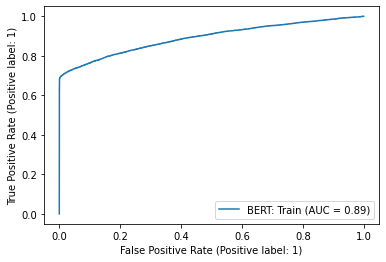

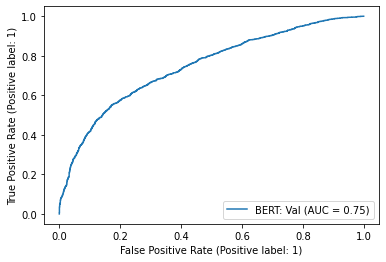

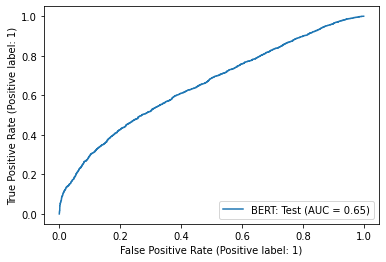

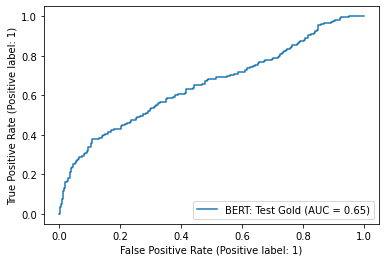

In [135]:
#Create the ROC Curve

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(true_labels_train_forinf, predicted_labels_train_forinf[:,1])
RocCurveDisplay.from_predictions(true_labels_train_forinf, predicted_labels_train_forinf[:,1],name='BERT: Train')

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(true_labels_val, predicted_labels_val[:,1])
RocCurveDisplay.from_predictions(true_labels_val, predicted_labels_val[:,1],name='BERT: Val')

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(true_labels_test, predicted_labels_test[:,1])
RocCurveDisplay.from_predictions(true_labels_test, predicted_labels_test[:,1],name='BERT: Test')

fpr_gold, tpr_gold, thresholds_gold = metrics.roc_curve(true_labels_test_gold, predicted_labels_test_gold[:,1])
RocCurveDisplay.from_predictions(true_labels_test_gold, predicted_labels_test_gold[:,1],name='BERT: Test Gold')


results_df.loc['Train','AUC'] = sklearn.metrics.auc(fpr_train, tpr_train)
results_df.loc['Val','AUC'] = sklearn.metrics.auc(fpr_val, tpr_val)
results_df.loc['Test','AUC'] = sklearn.metrics.auc(fpr_test, tpr_test)
results_df.loc['Gold','AUC'] = sklearn.metrics.auc(fpr_gold, tpr_gold)

In [106]:
results_df

,Precision,Recall,F1,Support,Size,AUC
Train,0.995116,0.69058,0.914463,7081,16763,0.891547
Val,0.828571,0.241265,0.557264,1803,4184,0.746805
Test,0.822115,0.140049,0.416464,2442,5203,0.65305
Gold,0.391304,0.356436,0.383795,101,1114,0.738176


In [107]:
#Store rsults
results_df.to_csv(model_path + f'/loadBest{load_best}_loadLast{load_last}_bert_results.csv')

In [63]:
#results_df.to_csv(model_path + '/bert_results_eval_weak_labels.csv')

# Alternative Classifiers

## Random Classifier

In [64]:
def random_classifier_pred(input_data, p=0.5):
        pred = np.random.uniform(size=len(input_data))
        pred = pred < p
        pred * 1
        return pred

In [65]:
#Outputs a random probability fo reach input label
def random_classifier_prob(input_data):
        pred = np.random.uniform(size=len(input_data))
        probs = np.ones((len(input_data),2))
        probs[:,0] = pred
        probs[:,1] = 1- pred
        return probs

## Logistic Regression (Bag of Words)

In [66]:
import sklearn
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import string 


In [67]:
#COPY FROM ABOVE BUT JUST TO MAKE THIS COMPARTIMENTALISED

#Load data and merge in prediction from inference step (Would also be possible to load this from the huggingface dataset)
df_split_train_eval = pd.read_csv(model_path + '/data_train.csv')
df_split_val_eval = pd.read_csv(model_path + '/data_val.csv')
df_split_test_eval = pd.read_csv(model_path + '/data_test.csv')

#Take the loaded CSV files and set which label to evalute on 
#Create gold label
df_gold = pd.read_csv(RAW_DATA_DIR + '/gold_labels.csv',index_col=0)
df_gold.reset_index(inplace=True)
df_gold.rename(columns={"label_id":"id"},inplace=True)

#FOR NOW TURN ALL GOLD LABELS THAT WERE NOT SUPPLIER INTO 0 and all SPPLIER into 1 
df_gold.loc[df_gold['gold_label'] != 'Supplier','gold_label'] = 0
df_gold.loc[df_gold['gold_label'] == 'Supplier','gold_label'] = 1

df_split_test_eval = pd.merge(df_split_test_eval, df_gold, how='left', on='id')
print("Distribution of Test Set")
print(df_split_test_eval['gold_label'].value_counts(dropna=False,normalize=True))
df_split_test_eval





Distribution of Test Set
NaN    0.785893
0.0    0.194695
1.0    0.019412
Name: gold_label, dtype: float64


,id_,start_sent,end_sent,relation,entity1_full,entity2_full,num_sentence,article,date_publish,source_domain,...,most_conf,pair,split,entity1,entity2,text,weak_label,prob_label_y,label,gold_label
0,14a66cf6e11b6a364ef60e05a6ee7cda44066892eb3aac...,10,11,NaN,AAC Technologies Holdings Inc,LG Innotek Co Ltd,2,14a66cf6e11b6a364ef60e05a6ee7cda44066892eb3aac...,2018-11-06 03:43:50,www.reuters.com,...,True,AAC Technologies Holdings Inc|LG Innotek Co Ltd,2,AAC,LG Innotek,Hong Kong-based acoustic components supplier A...,0,0.137192,0,0
1,1429be39f996af8c8d2401d9619b74a83b28c78744f7ce...,23,24,NaN,AAC Technologies Holdings Inc,LG Innotek Co Ltd,2,1429be39f996af8c8d2401d9619b74a83b28c78744f7ce...,2018-11-13 06:48:56,www.reuters.com,...,True,AAC Technologies Holdings Inc|LG Innotek Co Ltd,2,AAC,LG Innotek,"Among other Apple suppliers in Asia, Hong Kong...",0,0.037591,0,0
2,60ffdce3d957b21fe9113aa8d3d81bb8c451399dd19fba...,18,19,NaN,AAC Technologies Holdings Inc,LG Innotek Co Ltd,2,60ffdce3d957b21fe9113aa8d3d81bb8c451399dd19fba...,2018-11-06 06:48:24,www.reuters.com,...,True,AAC Technologies Holdings Inc|LG Innotek Co Ltd,2,AAC,LG Innotek,"Among other Apple suppliers in the region, Hon...",0,0.094364,0,0
3,47872121b7006c0d5df2d6caefdf26e391352c92ed8e5e...,28,29,NaN,AAC Technologies Holdings Inc,Panasonic Corp,2,47872121b7006c0d5df2d6caefdf26e391352c92ed8e5e...,2019-03-01 06:51:38,www.reuters.com,...,True,AAC Technologies Holdings Inc|Panasonic Corp,2,AAC,Panasonic,"AAC, a Hong Kong-listed acoustic component sup...",0,0.136569,0,0
4,893eb4400e70d0459c8b86e8cc115e30d39635855b43b7...,14,14,Supplier,Adobe Inc,Microsoft Corp,1,893eb4400e70d0459c8b86e8cc115e30d39635855b43b7...,2020-03-25 20:22:39,www.reuters.com,...,True,Adobe Inc|Microsoft Corp,2,Adobe,Microsoft,His firm sees opportunities in subscription-ba...,-1,0.500000,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5198,7d0f983559ec8324b79f66769b955c9facebc4a5fa8dc6...,54,54,NaN,Republic Services Inc,Alphabet Inc,1,7d0f983559ec8324b79f66769b955c9facebc4a5fa8dc6...,2019-07-19 18:05:29,www.reuters.com,...,True,Republic Services Inc|Alphabet Inc,2,Republic Services,Alphabet,Fortive Corp Q2 2019 Fortive Corp Earnings Rel...,0,0.000003,0,0
5199,7d0f983559ec8324b79f66769b955c9facebc4a5fa8dc6...,54,54,NaN,Republic Services Inc,Amazon.com Inc,1,7d0f983559ec8324b79f66769b955c9facebc4a5fa8dc6...,2019-07-19 18:05:29,www.reuters.com,...,True,Republic Services Inc|Amazon.com Inc,2,Republic Services,Amazon,Fortive Corp Q2 2019 Fortive Corp Earnings Rel...,0,0.000003,0,NaN
5200,ad26fa571b7f91f14e77c5494881bce2aecaecf5f43f0c...,21,22,Supplier,Semiconductor Manufacturing International Corp,Taiwan Semiconductor Manufacturing Co Ltd,2,ad26fa571b7f91f14e77c5494881bce2aecaecf5f43f0c...,2020-04-16 10:39:58,www.reuters.com,...,True,Semiconductor Manufacturing International Corp...,2,SMIC,TSMC,"TSMC, for example, is currently perfecting its...",-1,0.500000,-1,NaN
5201,f7d032313bb2d0213340f6ff96a05a84eadd37d64622c2...,3,3,NaN,Tesla Inc,AT&T Inc,1,f7d032313bb2d0213340f6ff96a05a84eadd37d64622c2...,2022-02-01 16:16:14,www.reuters.com,...,True,Tesla Inc|AT&T Inc,2,Tesla,AT&T,** Li Auto Inc : up 2.8% BUZZ-U.S. shares of C...,0,0.013691,0,NaN


In [68]:
#importing stop words like in, the, of so that these can be removed from texts
#as these words dont help in determining the classes(Whether a sentence is toxic or not)
stop_words = _stop_words.ENGLISH_STOP_WORDS
#Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

In [69]:
#Create feature matrix from bag of words
vect = CountVectorizer(max_features= 5000, preprocessor=clean)
#Create a matrix of bag of word representations for each input
X_train_dtm = vect.fit_transform(df_split_train_eval['text_with_marker'].values)
X_val_dtm = vect.transform(df_split_val_eval['text_with_marker'].values)
X_test_dtm = vect.transform(df_split_test_eval['text_with_marker'].values)

data_with_gold_label = np.logical_not(df_split_test_eval["gold_label"].isnull())                              
X_test_dtm_gold = vect.transform(df_split_test_eval.loc[data_with_gold_label,'text_with_marker'].values)

In [70]:
#Get a list of all the available words in the vocabulary
for i in vect.get_feature_names_out()[:10]:
    print(i)

aac
aaplo
ab
ability
able
about
abroad
abu
acacia
acadia


In [71]:
#Logistic Regression
clf_lr = LogisticRegression(fit_intercept=True, solver='liblinear', random_state=42).fit(X_train_dtm, dataset['train']['label'])


In [72]:
predicted_train_logreg = clf_lr.predict_proba(X_train_dtm)
predicted_val_logreg = clf_lr.predict_proba(X_val_dtm)
predicted_test_logreg = clf_lr.predict_proba(X_test_dtm)
predicted_test_logreg_gold = clf_lr.predict_proba(X_test_dtm_gold)


### Evaluation of Simple Classifier

In [73]:
#Train Set
true_labels_train_forinf = df_split_train_eval.loc[:,evaluation_label]

#Val Set
true_labels_val = df_split_val_eval.loc[:,evaluation_label]

#Test Test 
true_labels_test = df_split_test_eval.loc[:,evaluation_label]

#Gold Label Test Set
true_labels_test_gold = df_split_test_eval.loc[data_with_gold_label,'gold_label'].astype("int64")


In [74]:
results_df_logreg = pd.DataFrame(index = ['Train','Val','Test','Gold'],columns = ['Precision','Recall','F1','Support','Size','AUC'])

In [75]:
#Print Results and store F-Score: Train Set
print("Train Set Performance:")
print("")
results_df_logreg.loc['Train',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_train_logreg.argmax(axis=1),true_labels_train_forinf,verbose=True)

Train Set Performance:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.953      0.637      0.867       7081      16763


In [76]:
#Print Results and store F-Score: Test Set
print("Validation Set Performance:")
print("")
results_df_logreg.loc['Val',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_val_logreg.argmax(axis=1),true_labels_val,verbose=True)

Validation Set Performance:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.677      0.300      0.541       1803       4184


In [77]:
#Print Results and store F-Score: Test Set
print("Test Set Performance:")
print("")
results_df_logreg.loc['Test',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_test_logreg.argmax(axis=1),true_labels_test,verbose=True)

Test Set Performance:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.599      0.148      0.372       2442       5203


In [78]:
#Print Results and store F-Score: Test Set
print("Test Set Performance on Gold Labels:")
print("")
results_df_logreg.loc['Gold',['Precision','Recall','F1','Support','Size']] = evaluate_predictions(predicted_test_logreg_gold.argmax(axis=1),true_labels_test_gold,verbose=True)

Test Set Performance on Gold Labels:

relation              precision     recall    f-score    support       size
------------------    ---------  ---------  ---------  ---------  ---------
supplier of               0.186      0.238      0.194        101       1114


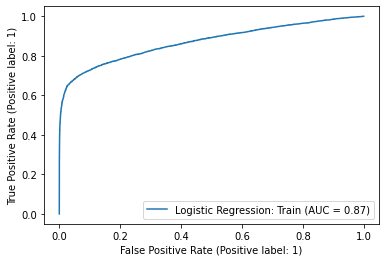

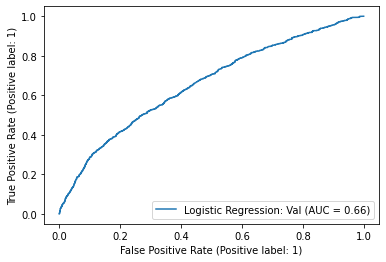

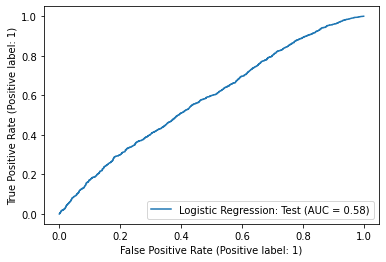

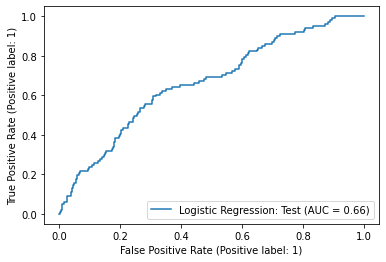

In [79]:
#Create the ROC Curve


fpr_logreg_train, tpr_logreg_train, thresholds_logreg_train = metrics.roc_curve(true_labels_train_forinf, predicted_train_logreg[:,1])
RocCurveDisplay.from_predictions(true_labels_train_forinf, predicted_train_logreg[:,1],name='Logistic Regression: Train')

fpr_logreg_val, tpr_logreg_val, thresholds_logreg_val = metrics.roc_curve(true_labels_val, predicted_val_logreg[:,1])
RocCurveDisplay.from_predictions(true_labels_val, predicted_val_logreg[:,1],name='Logistic Regression: Val')

fpr_logreg_test, tpr_logreg_test, thresholds_logreg_test = metrics.roc_curve(true_labels_test, predicted_test_logreg[:,1])
RocCurveDisplay.from_predictions(true_labels_test, predicted_test_logreg[:,1],name='Logistic Regression: Test')

fpr_logreg_gold, tpr_logreg_gold, thresholds_logreg_gold = metrics.roc_curve(true_labels_test_gold, predicted_test_logreg_gold[:,1])
RocCurveDisplay.from_predictions(true_labels_test_gold, predicted_test_logreg_gold[:,1],name='Logistic Regression: Test')

results_df_logreg.loc['Train','AUC'] = sklearn.metrics.auc(fpr_logreg_train, tpr_logreg_train)
results_df_logreg.loc['Val','AUC'] = sklearn.metrics.auc(fpr_logreg_val, tpr_logreg_val)
results_df_logreg.loc['Test','AUC'] = sklearn.metrics.auc(fpr_logreg_test, tpr_logreg_test)
results_df_logreg.loc['Gold','AUC'] = sklearn.metrics.auc(fpr_logreg_gold, tpr_logreg_gold)

In [80]:
results_df_logreg

,Precision,Recall,F1,Support,Size,AUC
Train,0.952502,0.637198,0.866726,7081,16763,0.870219
Val,0.676692,0.299501,0.540541,1803,4184,0.657041
Test,0.598673,0.14783,0.371858,2442,5203,0.584202
Gold,0.186047,0.237624,0.194489,101,1114,0.662936


In [81]:
results_df_logreg.to_csv(model_path + '/bow_results.csv')

In [82]:
#results_df_logreg.to_csv(model_path + '/bow_results_eval_weak_labels.csv')